# F105W SEP Tutorial

Install Numpy and Sep

In [1]:
import numpy as np
import sep

Then install additional libraries for reading the test image and displaying plots

In [2]:
import astropy.io.fits as fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Then read the image from the FITS file and display it

In [3]:
image_file = get_pkg_data_filename('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
image_file
fits.info(image_file)
image_data = fits.getdata(image_file, ext=0)
image_data = image_data.byteswap(inplace=True).newbyteorder()

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


Then display the image and save it as a png

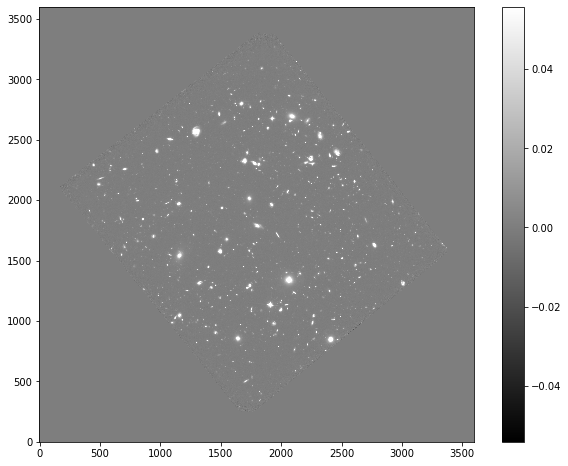

In [4]:
m, s = np.mean(image_data), np.std(image_data)
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("Image_f105w.png")
plt.show()

We can also measure a spatially varying background on the image 

In [5]:
bkg = sep.Background(image_data)

Then get the "global" mean and noise on the image background

In [6]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


Then evaluate the background as a 2-d array

In [7]:
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

And then we can display the background and save it as a png

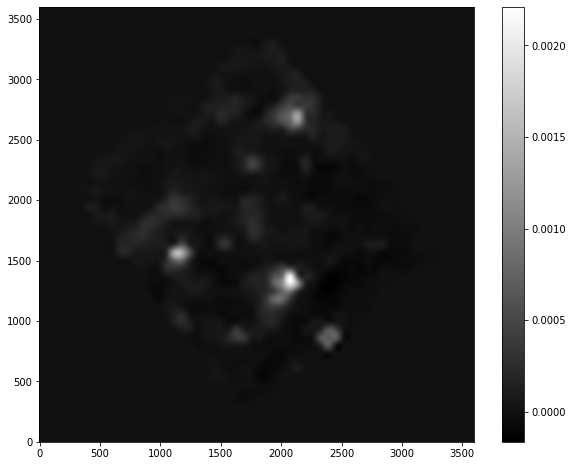

In [8]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("bkg_f105w.png")

We can also evalute the background noise as a 2-d array

In [9]:
bkg_rms = bkg.rms()

And then we can show the background noise and save it as a png:

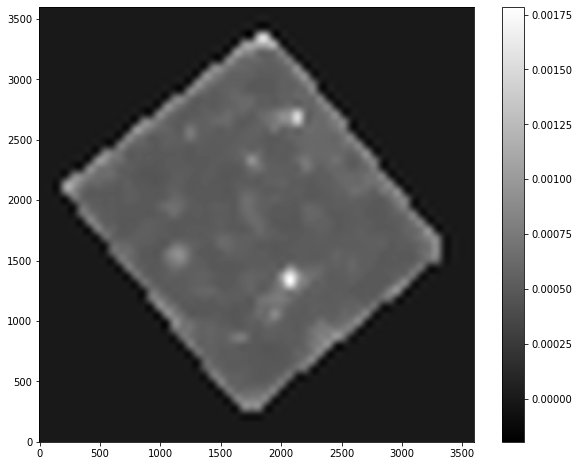

In [10]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("bkg_rms_f105w.png")

Then if we subtract the background, we can run object detection on the data:

In [11]:
# subtract the background
data_sub = image_data - bkg

In [12]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

And then we can see how many objects were detected which is 8640.

In [13]:
# how many objects were detected
len(objects)

8640

We can also plot the background subtracted image and plot an ellipse for each object

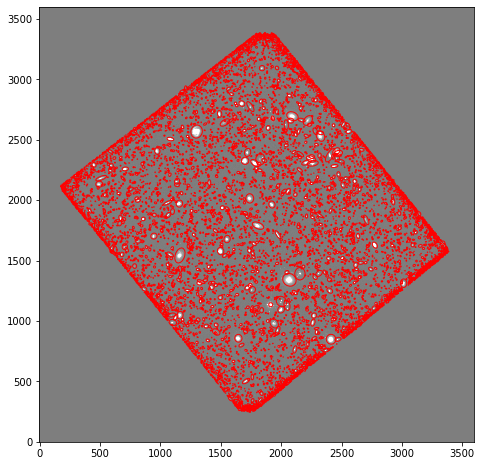

In [14]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig("patches_f105w.png")

We can also see the available fields of an object like so:

In [15]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Finally we can also perform circular aperture photometry with a 3 pixel radius at the location of the objects:

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [17]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


And then we can plot the fluxes on a histogram:

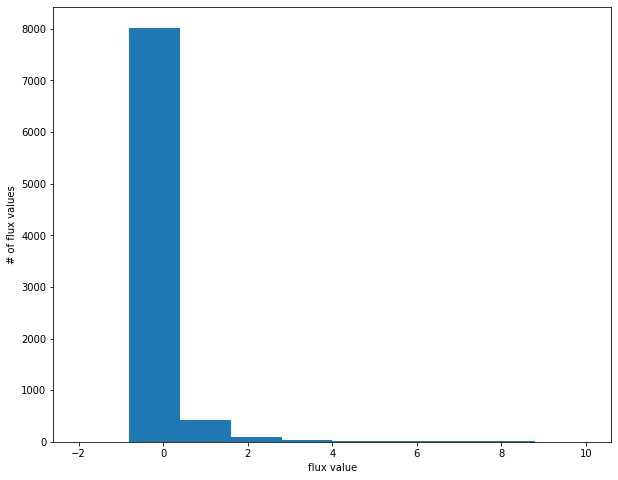

In [18]:
plt.hist(flux, range=[-2,10])
plt.xlabel("flux value")
plt.ylabel("# of flux values")
plt.show()

We can also find the mean, standard deviation, and median of the fluxes. The mean comes out to 0.00079129904, the standard deviation is 9.243527842776762, and the median is 0.030956558069156016. Lastly, the outlier is 807.2972835731507. 

In [19]:
mean, std, median = np.mean(flux), np.std(flux), np.median(flux)
outlier = np.max(flux)
m, std, median, outlier

(0.0007716763, 9.243527842776762, 0.030956558069156016, 807.2972835731507)

We can then find how many standard deviations the outlier is from the mean. We then find that it is ~87 standard deviations away.

In [20]:
numStds = (outlier - mean) / std
numStds

87.29734310293674